In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset,DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
import tarfile
from torchvision.datasets import ImageFolder

In [4]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

100.0%


In [6]:
with tarfile.open('./cifar10.tgz','r:gz') as tr:
    tr.extractall(path='./data')

In [2]:
import os
data_dir = './data/cifar10'

print(os.listdir(path = data_dir + '/train'))
classes = os.listdir(path = data_dir + '/train')
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

train_dataset = ImageFolder(root=train_dir,transform=ToTensor())
test_dataset = ImageFolder(root=test_dir,transform=ToTensor())

Text(0.5, 1.0, 'airplane')

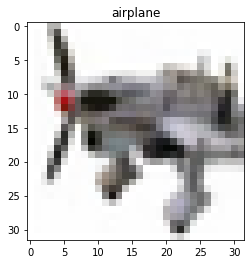

In [4]:
img,label = train_dataset[3]
plt.imshow(img.permute(1,2,0).numpy())
plt.title(classes[label])

Text(0.5, 1.0, 'airplane')

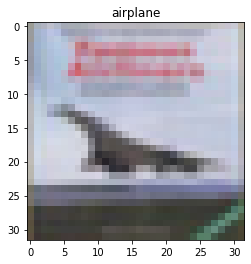

In [5]:
img,label = test_dataset[0]
plt.imshow(img.permute(1,2,0).numpy())
plt.title(classes[label])

In [6]:
# Constants

BATCH_SIZE = 128
random_seed = 42
Data_available = len(train_dataset)
training_data_size = int(0.85*Data_available)
validation_data_size = Data_available - training_data_size
print(training_data_size,validation_data_size)

torch.manual_seed(random_seed)

42500 7500


In [7]:
train_dl,val_dl = random_split(train_dataset,lengths=[training_data_size,validation_data_size])

In [8]:
train_dl = DataLoader(train_dl,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_dl,batch_size=BATCH_SIZE*2,num_workers=2,pin_memory=True)

In [9]:
def apply_kernel(image,kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    ro, co = ri-rk+1, ci-ck+1
    output = torch.zeros([ro,co])
    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck]*kernel)
    return output

In [10]:
sample_image = torch.tensor([
    [2,2,2,0,0,1],
    [1,1,1,1,1,1],
    [1,0,0,0,0,0],
    [2,3,5,6,7,8],
    [1,2,3,4,5,6]
],dtype=torch.float32)

sample_kernel = torch.tensor([
    [0,1,0],
    [0,1,0],
    [0,1,0]
],dtype=torch.float32)

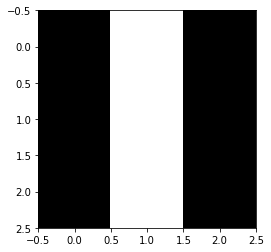

In [11]:
plt.imshow(sample_image.numpy(),cmap ='gray')
plt.imshow(sample_kernel.numpy(),cmap='gray')

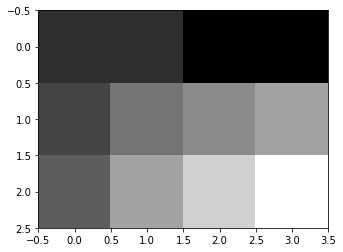

In [12]:
output = apply_kernel(sample_image,sample_kernel)
plt.imshow(output.numpy(),cmap = "gray")

In [13]:
dummpy_model = nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.Conv2d(8,32,kernel_size=3,stride=1,padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(32*16*16,10),
    nn.LogSoftmax()
)


In [14]:
for img,label in train_dl:
    print('Imput image Shape :- ',img.shape)
    out = dummpy_model(img)
    print('Output Images Shape :- ',out.shape)
    print(out)
    break

RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "C:\Users\prasa\miniconda3\envs\PyTorch\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 34, in _pin_memory_loop
    data = pin_memory(data)
  File "C:\Users\prasa\miniconda3\envs\PyTorch\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 58, in pin_memory
    return [pin_memory(sample) for sample in data]
  File "C:\Users\prasa\miniconda3\envs\PyTorch\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 58, in <listcomp>
    return [pin_memory(sample) for sample in data]
  File "C:\Users\prasa\miniconda3\envs\PyTorch\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 50, in pin_memory
    return data.pin_memory()
RuntimeError: cuda runtime error (2) : out of memory at ..\aten\src\THC\THCCachingHostAllocator.cpp:280


In [ ]:
def accuracy(output,label):
    _, pred = torch.max(output,dim=1)
    return torch.tensor(torch.sum(pred==label).item()/len(pred))

In [ ]:
class Image_Classification_Base(nn.Module):
    
    # Performs a step of feed-forward and calculates the cross entropy loss
    def training_step(self,batch):
        img, label = batch
        out = self(img)
        loss = F.cross_entropy(out, label)
        return loss
    
    def validation_step(self,batch):
        img, label = batch
        out = self(img)
        loss = F.cross_entropy(out,label)
        acc = accuracy(out,label)
        return {'val_loss':loss.detach(),'val_acc':acc}

    def validation_epoch_end(self,output):
        batch_loss = [x['val_loss']for x in output]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in output]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    def epoch_end(self,epoch_no,result):
        print("Epochs [{}], Train Loss :- {:4f}, Val Loss :- {:4f}, Val Accuracy :- {:4f}"
        .format(epoch_no,result['train_loss'],result['val_loss'],result['val_acc']))
    

In [ ]:
class CIFR10_CNN_Model(Image_Classification_Base):
    def __init__(self):
        super().__init__()
        self.Model = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(128,128,kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256,kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1,stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(256*4*4,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,512),
            nn.LeakyReLU(),
            nn.Linear(512,10),
            nn.LogSoftmax()
        )

    def forward(self,xb):
        return self.Model(xb)

In [ ]:
model = CIFR10_CNN_Model()
model

CIFR10_CNN_Model(
  (Model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.01)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1

In [ ]:
def get_default_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl) 
